In [82]:
# import necessary packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.dates import drange
import seaborn as sns 
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
sns.set
%matplotlib inline
plt.style.use('seaborn')

In [83]:
# import Gold, Equity(Vxus) and BTC data
#the entire year 2020
gld = pd.read_csv("C:/Users\BENEL ENERGY\PP\project 2\GLD (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
vxus = pd.read_csv("C:/Users\BENEL ENERGY\PP\project 2\VXUS (1).csv", index_col = 'Date', parse_dates = True)[['Adj Close']]
btc = pd.read_csv('C:/Users\BENEL ENERGY\PP\project 2\BTC-USD.csv', index_col = 'Date', parse_dates = True)[['Adj Close']]

#removing missing values
btc = btc.dropna()
vxus = vxus.dropna()
gld = gld.dropna()

In [84]:
#concatinating them together
df = pd.DataFrame(index = btc.index)
df['btc'] = btc['Adj Close']
start_date = '2020-01-01'
end_date = '2020-12-31'
df['gold'] = gld['Adj Close']
df['vxus'] = vxus['Adj Close']

df = df.dropna()


In [85]:
# first divide the assets by quarters

# Start of Q2 2020
Q2_Start = '2020-04-01'

# End of Q2 2020
Q2_End = '2020-06-30'

# Start of Q3 2020
Q3_Start = '2020-07-01'

# End of Q3 2020
Q3_End = '2020-09-30'

# Start of Q4 2020
Q4_Start = '2020-10-01'

# End of Q4 2020
Q4_End = '2020-12-31'

#data in quaters
df_Q2 = df[Q2_Start:Q2_End]
df_Q3 = df[Q3_Start:Q3_End]
df_Q4 = df[Q4_Start:Q4_End]

#### Test for Sationarity of dataset

In [86]:
#first check for stationarity
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Result: Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Result: Data has a unit root and is non-stationary")

In [87]:
# we are going to be using gold and equity 

In [88]:
#For Q2 in Gold
adf_test(df_Q2.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -3.439888
p-value                  0.009672
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [89]:
#For Q3 in Gold
adf_test(df_Q3.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -2.200680
p-value                  0.205999
# lags used              6.000000
# observations          57.000000
critical value (1%)     -3.550670
critical value (5%)     -2.913766
critical value (10%)    -2.594624
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [90]:
#For Q2 in Vxus
adf_test(df_Q2.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic      -1.788990
p-value                  0.385941
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [91]:
#For Q3 in Vxus 
adf_test(df_Q3.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic      -3.181259
p-value                  0.021095
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [92]:
#For Q2 in btc
adf_test(df_Q2.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic      -1.999821
p-value                  0.286652
# lags used              0.000000
# observations          61.000000
critical value (1%)     -3.542413
critical value (5%)     -2.910236
critical value (10%)    -2.592745
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


In [93]:
#For Q3 in btc 
adf_test(df_Q3.btc, title = 'BTC')

Augmented Dickey-Fuller Test: BTC
ADF test statistic      -1.775108
p-value                  0.392888
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Result: Data has a unit root and is non-stationary


Since for the first analysis we will be fitting Q2 and Q3 data in a VAR/VARMA model therefore there Q2 series has to be stationary 
and for the second analysis we are going to fit a VAR/VARMA model to Q3 series (here it will have to be stationary as well)

In [94]:
# Now to difference the non-stationary series

In [95]:
df_new =df[['vxus','gold','btc']]
df_new = df_new.diff()[1:]

df_Q2_s = df_new[['btc', 'vxus']][Q2_Start:Q2_End]
df_Q2_s['gold'] = df_Q2.gold 

df_Q3_s = df_new[['btc', 'gold']][Q3_Start:Q3_End]
df_Q3_s['gold'] = df_Q3.vxus


In [96]:
#For Q2 in Vxus
adf_test(df_Q2_s.vxus, title = 'equity')

Augmented Dickey-Fuller Test: equity
ADF test statistic     -1.027085e+01
p-value                 4.005262e-18
# lags used             0.000000e+00
# observations          6.100000e+01
critical value (1%)    -3.542413e+00
critical value (5%)    -2.910236e+00
critical value (10%)   -2.592745e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [97]:
#For Q3 in Gold
adf_test(df_Q3_s.gold, title = 'Gold')

Augmented Dickey-Fuller Test: Gold
ADF test statistic      -3.181259
p-value                  0.021095
# lags used              0.000000
# observations          63.000000
critical value (1%)     -3.538695
critical value (5%)     -2.908645
critical value (10%)    -2.591897
Strong evidence against the null hypothesis
Reject the null hypothesis
Result: Data has no unit root and is stationary


In [98]:
### Now all the series are stationary

## Model: Category 2

### VAR(Train Q2 and Test Q3) (Traded: EQUITY,  EXO: GOLD)

In [164]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary


train = df_new[['vxus', 'gold']][Q2_Start:Q2_End]
test = df_Q3[['vxus', 'gold']]
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 0.44456776428107225


ORDER 2
AIC: 0.5725568346448102


ORDER 3
AIC: 0.7030878354969274


ORDER 4
AIC: 0.4489115054979784


ORDER 5
AIC: 0.575685378080759


ORDER 6
AIC: 0.6196291262520999


ORDER 7
AIC: 0.5574919745880013




In [165]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Oct, 2021
Time:                     17:49:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.652195
Nobs:                     61.0000    HQIC:                  0.525939
Log likelihood:          -180.670    FPE:                    1.56006
AIC:                     0.444568    Det(Omega_mle):         1.41724
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.174294         0.096919            1.798           0.072
L1.vxus        -0.242442         0.122522           -1.979           0.048
L1.gold        -0.007316         0.058490           -0.125           0.900

Results f

In [166]:
lagged_values = train.values[-1:]
lagged_values

array([[-0.087162,  0.73999 ]])

In [167]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q3_Start, periods = 66, freq='B')
#idx

In [168]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast
2020-07-01,0.190012,0.353451
2020-07-02,0.125641,0.261960
2020-07-03,0.141917,0.293617
2020-07-06,0.137739,0.285123
2020-07-07,0.138814,0.287324
...,...,...
2020-09-24,0.138594,0.286873
2020-09-25,0.138594,0.286873
2020-09-28,0.138594,0.286873
2020-09-29,0.138594,0.286873


In [169]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [170]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q2_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q2_End]+df_forecast['Gold_Forecast'].cumsum()

In [171]:
df_test=df_forecast[['Equity_forecast','Gold_forecast']]

In [172]:
test = df_test.merge(test, on='Date')
test.tail()

,Equity_forecast,Gold_forecast,vxus,gold
Date,,,,
2020-09-24,55.974116,184.622666,50.000565,175.440002
2020-09-25,56.112710,184.909539,50.185753,174.940002
2020-09-28,56.251304,185.196413,50.868019,176.699997
2020-09-29,56.389899,185.483286,50.799789,178.190002
2020-09-30,56.528493,185.770159,50.848522,177.119995


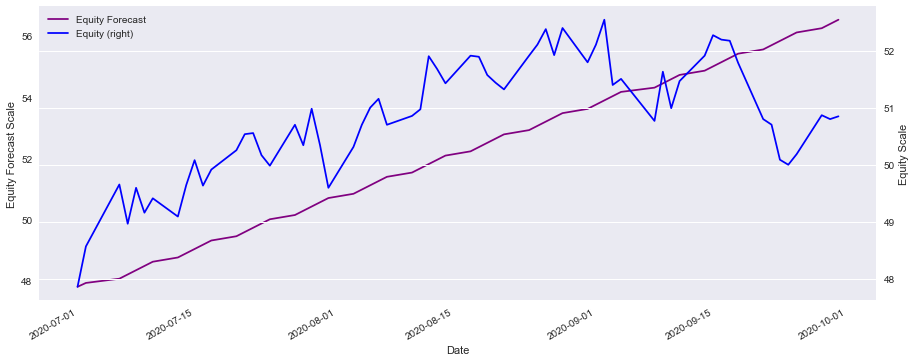

In [173]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

#### Evaluation of VAR model for (Q2 train and Q3 test)

In [174]:
#EQUITY

print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 1.732782246432235
MSE 5.988850829255645
RMSE 2.4472128696244724


### VAR (train Q3 and test Q4)

In [175]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary

train = df_new[['vxus','gold']][Q3_Start:Q3_End]
test = df_Q4[['vxus','gold']]
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 0.2575016010943054


ORDER 2
AIC: 0.3518440829776113


ORDER 3
AIC: 0.37337263851189867


ORDER 4
AIC: 0.4085003648745221


ORDER 5
AIC: 0.519963216003074


ORDER 6
AIC: 0.4816341755699529


ORDER 7
AIC: 0.6308990979054776




In [176]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Oct, 2021
Time:                     17:52:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.461610
Nobs:                     63.0000    HQIC:                  0.337778
Log likelihood:          -180.898    FPE:                    1.29388
AIC:                     0.257502    Det(Omega_mle):         1.17893
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.061388         0.062168            0.987           0.323
L1.vxus        -0.187781         0.131148           -1.432           0.152
L1.gold        -0.026314         0.028270           -0.931           0.352

Results f

In [177]:
lagged_values = train.values[-1:]
lagged_values

array([[ 0.048733, -1.070007]])

In [178]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q4_Start, periods = 66, freq='B')
#idx

In [179]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast
2020-10-01,0.080393,0.128616
2020-10-02,0.042907,0.171332
2020-10-05,0.048822,0.165146
2020-10-06,0.047874,0.166139
2020-10-07,0.048026,0.165980
...,...,...
2020-12-25,0.048005,0.166002
2020-12-28,0.048005,0.166002
2020-12-29,0.048005,0.166002
2020-12-30,0.048005,0.166002


In [180]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [181]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q3_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q3_End]+df_forecast['Gold_Forecast'].cumsum()

In [182]:
df_test=df_forecast[['Equity_forecast','Gold_forecast']]

<AxesSubplot:ylabel='Date'>

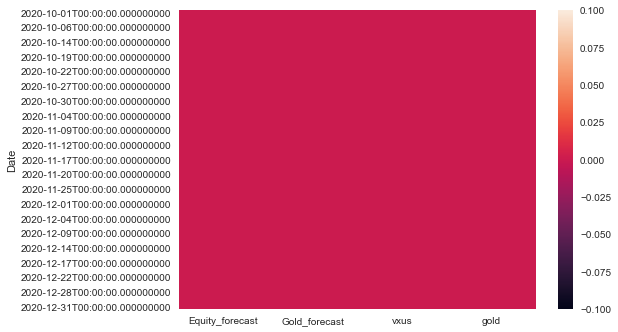

In [183]:
test = df_test.merge(test, on='Date')
sns.heatmap(test.isnull())


### Charts of Predictions vs Actual

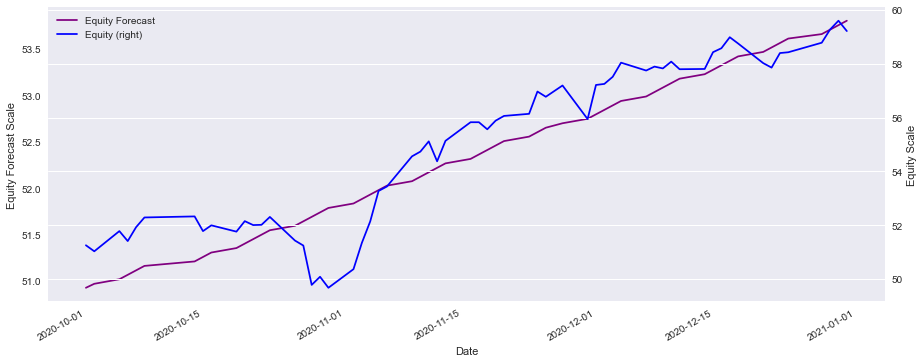

In [184]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

In [185]:
#EQUITY

print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 2.9303493979129165
MSE 12.11531228139257
RMSE 3.4807057159996404


### Pair Trading

In [186]:
# Q2(Train) and Q3(Test)

In [187]:
X = df['gold']
y = df['vxus']

x1 = sm.add_constant(X)#constant
model = sm.OLS(y,x1)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vxus   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     51.11
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           9.82e-12
Time:                        17:55:08   Log-Likelihood:                -743.71
No. Observations:                 249   AIC:                             1491.
Df Residuals:                     247   BIC:                             1498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0526      3.893      5.664      0.000      14.384      29.721
gold           0.1666      0.023      7.149      0.000       0.121       0.213
==============================================================================
Omnibus:                       26.981   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.516
Skew:                           0.088   Prob(JB):                       0.0141
Kurtosis:                       2.111   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

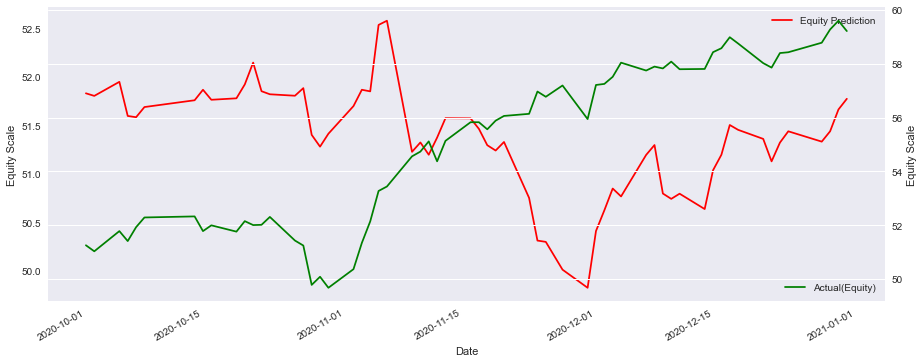

In [188]:
#Calculating Spread()
testing_y = df
testing_y['Equity Prediction']=results.params[0]+((results.params[1])*testing_y.gold)
testing_y['Spread']=testing_y.vxus - (testing_y.gold*(results.params[1]))-(results.params[0])

#pair trading 
testing_y['100_Day_Spread_Avg'] = testing_y.Spread.rolling(window=100).mean().dropna()
testing_y['100_Day_Spread_Stdev'] = testing_y.Spread.rolling(window=100).std().dropna()
testing_y['z-score']=(testing_y['Spread'] - testing_y['100_Day_Spread_Avg'])/(testing_y['100_Day_Spread_Stdev']).dropna()
testing_y=testing_y.dropna()
testing_y=testing_y[Q4_Start:Q4_End]
testing_y['Signal']=np.where(testing_y['z-score']>2, "buy(long) Bitcoin and sell(short) Equity",
                            np.where(testing_y['z-score']<-2, "buy Equity and sell Bitcoin",
                                     np.where(testing_y['z-score']<0.5, "sell the two stocks (limit our exposure)","Not Trade")))

testing_y['Equity Prediction'].plot(figsize=(15,6), color= 'red', label='Equity Prediction').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
testing_y['vxus'].plot(secondary_y= True, color = 'green',label ='Actual(Equity)').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
plt.show()

In [189]:
#Calculate forecast bias
forecast_errors = [testing_y['vxus'][i]- testing_y['Equity Prediction'][i] for i in range(len(testing_y['vxus']))]
bias = sum(forecast_errors) * 1.0/len(testing_y['vxus'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(testing_y['vxus'],testing_y['Equity Prediction'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(testing_y['vxus'], testing_y['Equity Prediction'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 3.660572
MAE: 3.966311
MSE: 24.539217
RMSE: 4.953707


In [190]:
### Write note compare the model thus far and also explain it relation to cointergration using content from module 7 (Pair Trading)

### VECM (Q2 - train and Q3 - test)

In [192]:
#Q2 (Train) and Q3 (test)
train_Q2 = df[['gold', 'vxus']][Q2_Start:Q2_End] 
train_Q3 = df[['gold', 'vxus']][Q3_Start:Q3_End]

test_Q2 = df[['gold', 'vxus']][Q3_Start:Q3_End]
test_Q4 =df[['gold', 'vxus']][Q4_Start:Q4_End]

In [193]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(df, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset


grangers_causality_matrix(train_Q2, variables = train.columns)

,vxus_x,gold_x
vxus_y,1.0000,0.0061
gold_y,0.1129,1.0000


In [194]:
grangers_causality_matrix(train_Q3, variables = train.columns)

,vxus_x,gold_x
vxus_y,1.0000,0.0061
gold_y,0.1129,1.0000


#### Past Bitcoin(x) values can help anticipate Equity(y) if the impacts of past Bitcoin prices on Equity have already been taken into consideration.
#### Past values of Equity(x) aid in the prediction of Bitcoin(y), assuming that the impacts of past values of Equity on Bitcoin have already been accounted for.
#### We can forecast these values using the VECM model. 

In [195]:
# Q2(Train) and Q3 (Test)

In [196]:
VECM_model = VECM(train_Q2, coint_rank=2)
vecm_res = VECM_model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0669,0.128,-0.523,0.601,-0.318,0.184
L1.vxus,-0.3321,0.275,-1.206,0.228,-0.872,0.208
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0254,0.058,-0.440,0.660,-0.138,0.087
L1.vxus,-0.2031,0.124,-1.640,0.101,-0.446,0.040
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0033,0.024,-0.136,0.892,-0.051,0.044
ec2,0.0191,0.088,0.216,0.829,-0.154,0.192
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0175,0.011,1.594,0.111,-0.004,0.039


In [197]:
x =vecm_res.predict(steps =66)
idx = pd.date_range('2020-07-01', periods = 66, freq='B')
df_VECM_forecast = pd.DataFrame(data =x, index = idx, columns =['Gold_FC','Equity_FC'])
df_VECM_forecast.index.names = ['Date']
df_VECM_forecast = test_Q2.merge(df_VECM_forecast, on='Date')
df_VECM_forecast.head()

,gold,vxus,Gold_FC,Equity_FC
Date,,,,
2020-07-01,166.619995,47.862793,167.700851,47.712305
2020-07-02,166.979996,48.569794,168.000355,47.778331
2020-07-06,167.979996,49.654503,168.618308,47.924295
2020-07-07,169.039993,48.966877,168.926671,47.998197
2020-07-08,170.089996,49.596390,169.234945,48.072816


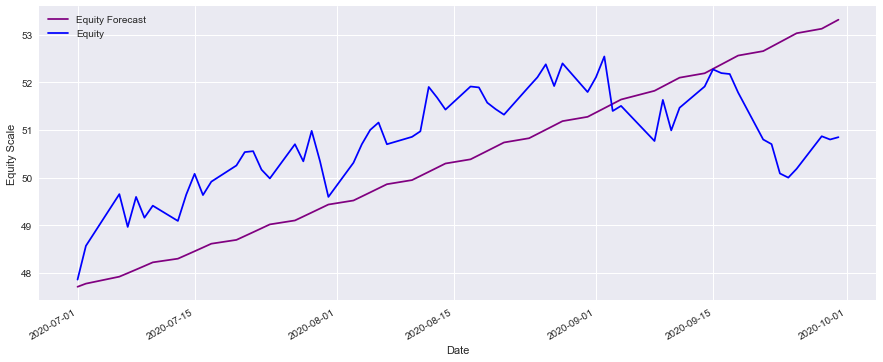

In [198]:
df_VECM_forecast.Equity_FC.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_VECM_forecast.vxus.plot(color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

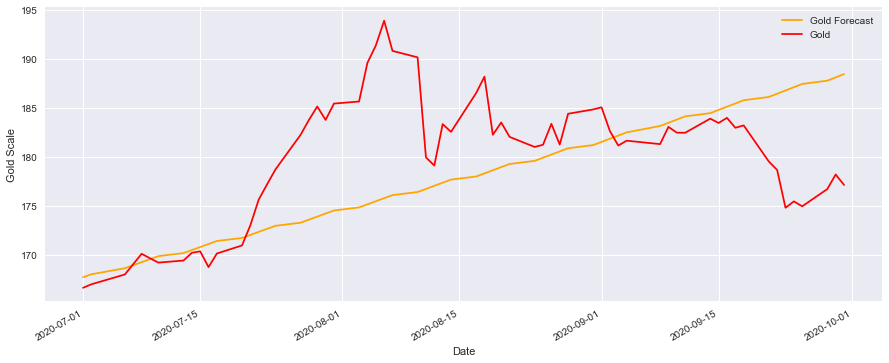

In [199]:
df_VECM_forecast.Gold_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.gold.plot(color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

In [200]:
#Calculate forecast bias
forecast_errors = [df_VECM_forecast['vxus'][i]- df_VECM_forecast['Equity_FC'][i] for i in range(len(df_VECM_forecast['vxus']))]
bias = sum(forecast_errors) * 1.0/len(df_VECM_forecast['Equity_FC'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(df_VECM_forecast['vxus'],df_VECM_forecast['Equity_FC'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(df_VECM_forecast['vxus'], df_VECM_forecast['Equity_FC'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 0.420321
MAE: 1.181519
MSE: 1.835399
RMSE: 1.354769


### VECM model for Q3 - train and Q4 - test

In [201]:
# Q3 (Train) and Q4 (Test)

In [202]:
VECM_model = VECM(train_Q3, coint_rank=2)
vecm_res = VECM_model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,0.0804,0.132,0.607,0.544,-0.179,0.340
L1.vxus,-0.0718,0.619,-0.116,0.908,-1.285,1.142
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0249,0.028,-0.891,0.373,-0.080,0.030
L1.vxus,-0.1922,0.131,-1.471,0.141,-0.448,0.064
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.1163,0.061,-1.916,0.055,-0.235,0.003
ec2,0.4142,0.215,1.929,0.054,-0.007,0.835
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0034,0.013,0.262,0.794,-0.022,0.028


In [203]:
x =vecm_res.predict(steps =66)
idx = pd.date_range('2020-10-01', periods = 66, freq='B')
df_VECM_forecast = pd.DataFrame(data =x, index = idx, columns =['Gold_FC','Equity_FC'])
df_VECM_forecast.index.names = ['Date']
df_VECM_forecast = test_Q4.merge(df_VECM_forecast, on='Date')
df_VECM_forecast.head()

,gold,vxus,Gold_FC,Equity_FC
Date,,,,
2020-10-01,178.699997,51.257885,177.493531,50.904006
2020-10-02,178.539993,51.033714,177.962155,50.922900
2020-10-05,179.410004,51.784210,178.394373,50.947825
2020-10-06,177.300003,51.413834,178.783288,50.973672
2020-10-07,177.220001,51.930405,179.134130,51.001442


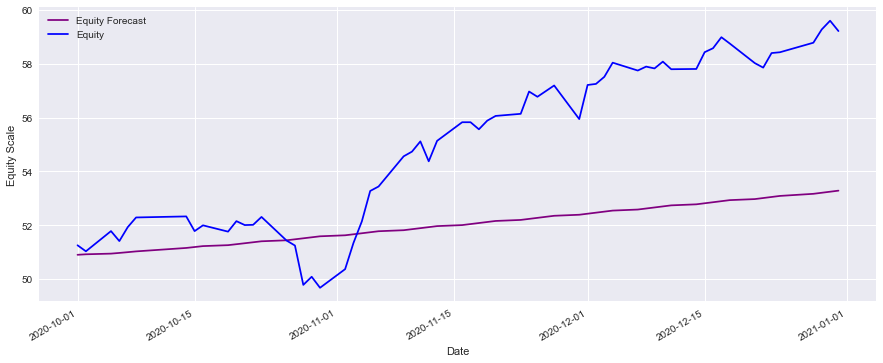

In [204]:
df_VECM_forecast.Equity_FC.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_VECM_forecast.vxus.plot(color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

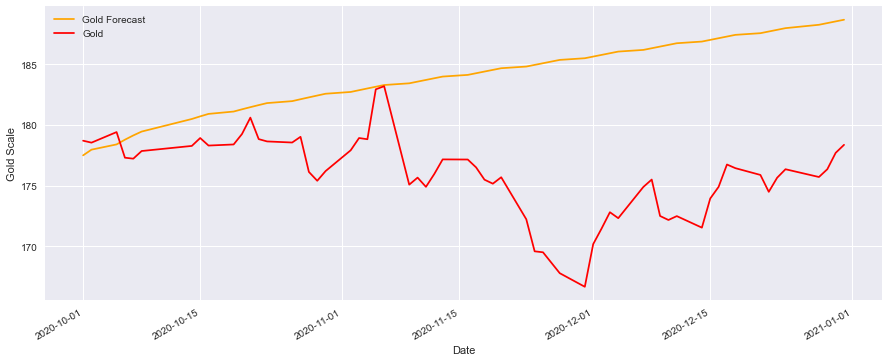

In [205]:
df_VECM_forecast.Gold_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.gold.plot(color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

In [206]:
#Calculate forecast bias
forecast_errors = [df_VECM_forecast['vxus'][i]- df_VECM_forecast['Equity_FC'][i] for i in range(len(df_VECM_forecast['vxus']))]
bias = sum(forecast_errors) * 1.0/len(df_VECM_forecast['Equity_FC'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(df_VECM_forecast['vxus'],df_VECM_forecast['Equity_FC'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(df_VECM_forecast['vxus'], df_VECM_forecast['Equity_FC'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 2.958267
MAE: 3.185424
MSE: 14.396518
RMSE: 3.794274


## Model: Category 3

### VAR(Train Q2 and Test Q3) (Variables: EQUITY,   GOLD and Bitcion)

In [99]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary


train = df_new[Q2_Start:Q2_End]
test = df_Q3
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 12.011273853940434


ORDER 2
AIC: 12.251600835308787


ORDER 3
AIC: 12.470350189491189


ORDER 4
AIC: 12.30700240847715


ORDER 5
AIC: 12.502642193220707


ORDER 6
AIC: 12.489015009237256


ORDER 7
AIC: 12.410931388797088




In [100]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Oct, 2021
Time:                     17:35:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.4265
Nobs:                     61.0000    HQIC:                   12.1740
Log likelihood:          -614.010    FPE:                    164693.
AIC:                      12.0113    Det(Omega_mle):         136121.
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.174208         0.097800            1.781           0.075
L1.vxus        -0.243824         0.130564           -1.867           0.062
L1.gold        -0.008008         0.062650           -0.128           0.898
L1.btc    

In [101]:
lagged_values = train.values[-1:]
lagged_values

array([[ -0.087162,   0.73999 , -52.861328]])

In [102]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q3_Start, periods = 66, freq='B')
#idx

In [103]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast', 'Bitcoin_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast,Bitcoin_Forecast
2020-07-01,0.188993,0.333290,48.474184
2020-07-02,0.125954,0.261916,33.223913
2020-07-03,0.141740,0.291484,42.835245
2020-07-06,0.137753,0.284421,39.800095
2020-07-07,0.138750,0.286053,40.569337
...,...,...,...
2020-09-24,0.138551,0.285736,40.418811
2020-09-25,0.138551,0.285736,40.418811
2020-09-28,0.138551,0.285736,40.418811
2020-09-29,0.138551,0.285736,40.418811


In [104]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [105]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q2_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q2_End]+df_forecast['Gold_Forecast'].cumsum()
df_forecast['Bitcoin_forecast'] = df['btc'][Q2_End]+df_forecast['Bitcoin_Forecast'].cumsum()

In [106]:
df_test=df_forecast[['Equity_forecast','Gold_forecast', 'Bitcoin_forecast']]

In [107]:
test = df_test.merge(test, on='Date')
test.tail()

,Equity_forecast,Gold_forecast,Bitcoin_forecast,btc,gold,vxus
Date,,,,,,
2020-09-24,55.970959,184.536822,11563.484447,10745.548828,175.440002,50.000565
2020-09-25,56.109511,184.822557,11603.903258,10702.290039,174.940002,50.185753
2020-09-28,56.248062,185.108293,11644.322068,10721.327148,176.699997,50.868019
2020-09-29,56.386614,185.394029,11684.740879,10848.830078,178.190002,50.799789
2020-09-30,56.525165,185.679765,11725.159690,10787.618164,177.119995,50.848522


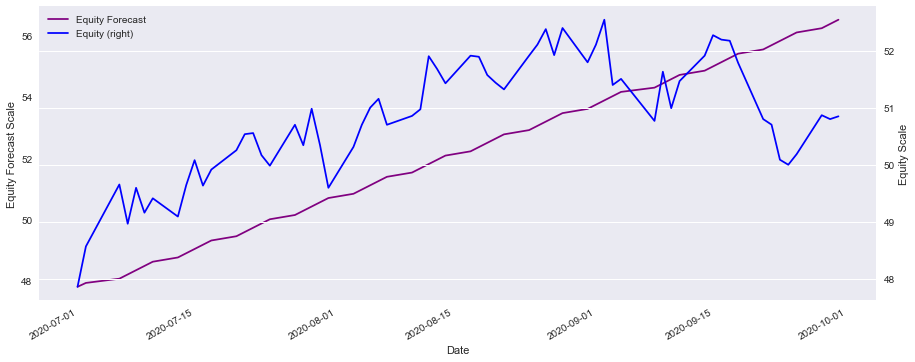

In [108]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

#### Evaluation of VAR model for (Q2 train and Q3 test)

In [109]:
#EQUITY
print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 1.731475066385554
MSE 5.980596598378831
RMSE 2.445525832695053


### VAR (train Q3 and test Q4)

In [110]:
# since for VAR the variables must stationary so we are going to use the differenced series
# vxus data was differenced but gold was originally stationary

train = df_new[Q3_Start:Q3_End]
test = df_Q4
model = VAR (train)

for p in range(1, 8):
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC: {results.aic}')
    print('\n')

ORDER 1
AIC: 11.466273276289042


ORDER 2
AIC: 11.57875984206212


ORDER 3
AIC: 11.688028152102532


ORDER 4
AIC: 11.837793839754058


ORDER 5
AIC: 12.069749690409804


ORDER 6
AIC: 12.125738659478579


ORDER 7
AIC: 12.149338201042184




In [111]:
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Oct, 2021
Time:                     17:35:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.8745
Nobs:                     63.0000    HQIC:                   11.6268
Log likelihood:          -617.367    FPE:                    95490.9
AIC:                      11.4663    Det(Omega_mle):         79388.8
--------------------------------------------------------------------
Results for equation vxus
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.061650         0.062693            0.983           0.325
L1.vxus        -0.178869         0.141484           -1.264           0.206
L1.gold        -0.023619         0.032315           -0.731           0.465
L1.btc    

In [112]:
lagged_values = train.values[-1:]
lagged_values

array([[ 4.8733000e-02, -1.0700070e+00, -6.1211914e+01]])

In [113]:
z =results.forecast(y=lagged_values, steps =66)
idx = pd.date_range(Q4_Start, periods = 66, freq='B')
#idx

In [114]:
df_forecast = pd.DataFrame(data =z, index = idx, columns =['Equity_Forecast','Gold_Forecast', 'Bitcoin_Forecast'])
df_forecast

,Equity_Forecast,Gold_Forecast,Bitcoin_Forecast
2020-10-01,0.080855,0.132411,19.319562
2020-10-02,0.043224,0.175675,21.536071
2020-10-05,0.048838,0.166895,26.322352
2020-10-06,0.047834,0.166265,24.979632
2020-10-07,0.048086,0.166435,25.248408
...,...,...,...
2020-12-25,0.048037,0.166420,25.200357
2020-12-28,0.048037,0.166420,25.200357
2020-12-29,0.048037,0.166420,25.200357
2020-12-30,0.048037,0.166420,25.200357


In [115]:
df_forecast.index.names = ['Date']
df_forecast.columns

df_forecast = test.merge(df_forecast, on='Date')
#df_forecast

In [116]:
# undifferencing the series
df_forecast['Equity_forecast'] = df['vxus'][Q3_End]+df_forecast['Equity_Forecast'].cumsum()
df_forecast['Gold_forecast'] = df['gold'][Q3_End]+df_forecast['Gold_Forecast'].cumsum()
df_forecast['Bitcoin_forecast'] = df['btc'][Q3_End]+df_forecast['Bitcoin_Forecast'].cumsum()

In [117]:
df_test=df_forecast[['Equity_forecast','Gold_forecast', 'Bitcoin_forecast']]

In [118]:
test = df_test.merge(test, on='Date')


### Charts on Predictions vs Actual

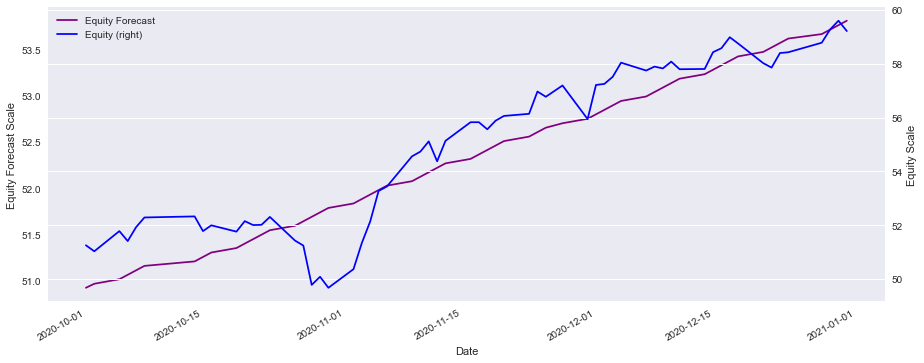

In [119]:
df_forecast.Equity_forecast.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_forecast.vxus.plot(secondary_y = True,color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

In [120]:
#EQUITY

print('MAE:', metrics.mean_absolute_error(test.vxus, test.Equity_forecast))
print('MSE', metrics.mean_squared_error(test.vxus, test.Equity_forecast))
print('RMSE', np.sqrt(metrics.mean_squared_error(test.vxus, test.Equity_forecast)))

MAE: 2.928999351322758
MSE 12.104431161568948
RMSE 3.479142302575298


### grangers_causality_matrix

In [121]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(df, variables, test = 'ssr_chi2test', verbose=False):
    
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(df[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

grangers_causality_matrix(df, variables = df.columns)

,btc_x,gold_x,vxus_x
btc_y,1.0000,0.1526,0.4607
gold_y,0.1306,1.0000,0.0080
vxus_y,0.0107,0.0226,1.0000


### Pair Trading for gold and Equity

In [66]:
# Q2(Train) and Q3(Test)

In [67]:
X = df['gold']
y = df['vxus']

x1 = sm.add_constant(X)#constant
model = sm.OLS(y,x1)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vxus   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     51.11
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           9.82e-12
Time:                        16:51:31   Log-Likelihood:                -743.71
No. Observations:                 249   AIC:                             1491.
Df Residuals:                     247   BIC:                             1498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0526      3.893      5.664      0.000      14.384      29.721
gold           0.1666      0.023      7.149      0.000       0.121       0.213
==============================================================================
Omnibus:                       26.981   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.516
Skew:                           0.088   Prob(JB):                       0.0141
Kurtosis:                       2.111   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

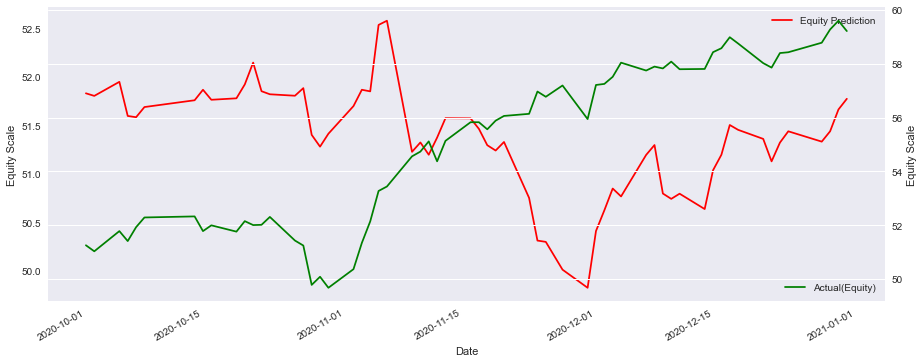

In [68]:
#Calculating Spread()
testing_y = df
testing_y['Equity Prediction']=results.params[0]+((results.params[1])*testing_y.gold)
testing_y['Spread']=testing_y.vxus - (testing_y.gold*(results.params[1]))-(results.params[0])

#pair trading 
testing_y['100_Day_Spread_Avg'] = testing_y.Spread.rolling(window=100).mean().dropna()
testing_y['100_Day_Spread_Stdev'] = testing_y.Spread.rolling(window=100).std().dropna()
testing_y['z-score']=(testing_y['Spread'] - testing_y['100_Day_Spread_Avg'])/(testing_y['100_Day_Spread_Stdev']).dropna()
testing_y=testing_y.dropna()
testing_y=testing_y[Q4_Start:Q4_End]
testing_y['Signal']=np.where(testing_y['z-score']>2, "buy(long) Bitcoin and sell(short) Equity",
                            np.where(testing_y['z-score']<-2, "buy Equity and sell Bitcoin",
                                     np.where(testing_y['z-score']<0.5, "sell the two stocks (limit our exposure)","Not Trade")))

testing_y['Equity Prediction'].plot(figsize=(15,6), color= 'red', label='Equity Prediction').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
testing_y['vxus'].plot(secondary_y= True, color = 'green',label ='Actual(Equity)').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
plt.show()

In [69]:
#Calculate forecast bias
forecast_errors = [testing_y['vxus'][i]- testing_y['Equity Prediction'][i] for i in range(len(testing_y['vxus']))]
bias = sum(forecast_errors) * 1.0/len(testing_y['vxus'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(testing_y['vxus'],testing_y['Equity Prediction'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(testing_y['vxus'], testing_y['Equity Prediction'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 3.660572
MAE: 3.966311
MSE: 24.539217
RMSE: 4.953707


### Pair Trading for gold and BTC

In [72]:
# Q2(Train) and Q3(Test)

In [76]:
X = df['btc']
y = df['vxus']

x1 = sm.add_constant(X)#constant
model = sm.OLS(y,x1)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   vxus   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     308.9
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           2.08e-45
Time:                        16:56:26   Log-Likelihood:                -666.12
No. Observations:                 249   AIC:                             1336.
Df Residuals:                     247   BIC:                             1343.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.6403      0.620     63.953      0.000      38.419      40.861
btc            0.0009   5.18e-05     17.577      0.000       0.001       0.001
==============================================================================
Omnibus:                        4.025   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.068
Skew:                          -0.308   Prob(JB):                        0.131
Kurtosis:                       2.888   Cond. No.                     3.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

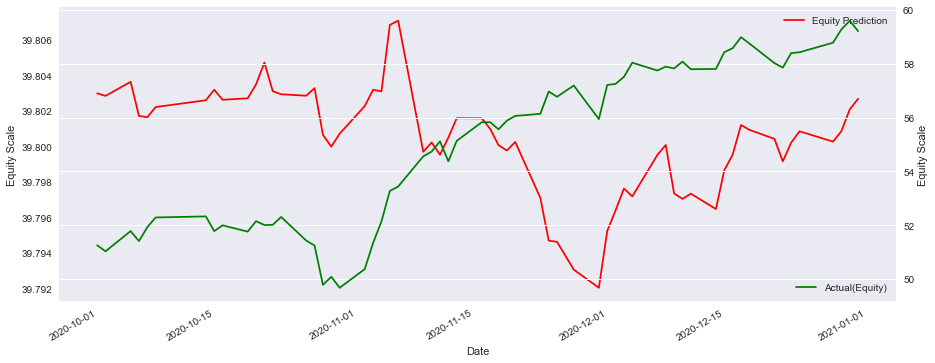

In [77]:
#Calculating Spread()
testing_y = df
testing_y['Equity Prediction']=results.params[0]+((results.params[1])*testing_y.gold)
testing_y['Spread']=testing_y.vxus - (testing_y.gold*(results.params[1]))-(results.params[0])

#pair trading 
testing_y['100_Day_Spread_Avg'] = testing_y.Spread.rolling(window=100).mean().dropna()
testing_y['100_Day_Spread_Stdev'] = testing_y.Spread.rolling(window=100).std().dropna()
testing_y['z-score']=(testing_y['Spread'] - testing_y['100_Day_Spread_Avg'])/(testing_y['100_Day_Spread_Stdev']).dropna()
testing_y=testing_y.dropna()
testing_y=testing_y[Q4_Start:Q4_End]
testing_y['Signal']=np.where(testing_y['z-score']>2, "buy(long) Bitcoin and sell(short) Equity",
                            np.where(testing_y['z-score']<-2, "buy Equity and sell Bitcoin",
                                     np.where(testing_y['z-score']<0.5, "sell the two stocks (limit our exposure)","Not Trade")))

testing_y['Equity Prediction'].plot(figsize=(15,6), color= 'red', label='Equity Prediction').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
testing_y['vxus'].plot(secondary_y= True, color = 'green',label ='Actual(Equity)').set_ylabel('Equity Scale')
plt.legend(loc = "lower right")
plt.show()

In [78]:
#Calculate forecast bias
forecast_errors = [testing_y['vxus'][i]- testing_y['Equity Prediction'][i] for i in range(len(testing_y['vxus']))]
bias = sum(forecast_errors) * 1.0/len(testing_y['vxus'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(testing_y['vxus'],testing_y['Equity Prediction'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(testing_y['vxus'], testing_y['Equity Prediction'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 15.224703
MAE: 15.224703
MSE: 240.887003
RMSE: 15.520535


In [70]:
### Write note compare the model thus far and also explain it relation to cointergration using content from module 7 (Pair Trading)

### VECM (Q2 - train and Q3 - test)

In [122]:
#Q2 (Train) and Q3 (test)
train_Q2 = df[['gold', 'vxus', 'btc']][Q2_Start:Q2_End] 
train_Q3 = df[['gold', 'vxus', 'btc']][Q3_Start:Q3_End]

test_Q2 = df[['gold', 'vxus', 'btc']][Q3_Start:Q3_End]
test_Q4 =df[['gold', 'vxus', 'btc']][Q4_Start:Q4_End]

In [123]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(df, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset


grangers_causality_matrix(train_Q2, variables = train.columns)

,vxus_x,gold_x,btc_x
vxus_y,1.0000,0.0061,0.0002
gold_y,0.1129,1.0000,0.8600
btc_y,0.2044,0.4515,1.0000


In [124]:
grangers_causality_matrix(train_Q3, variables = train.columns)

,vxus_x,gold_x,btc_x
vxus_y,1.0000,0.0061,0.0002
gold_y,0.1129,1.0000,0.8600
btc_y,0.2044,0.4515,1.0000


#### Past Bitcoin(x) values can help anticipate Equity(y) if the impacts of past Bitcoin prices on Equity have already been taken into consideration.
#### Past values of Equity(x) aid in the prediction of Bitcoin(y), assuming that the impacts of past values of Equity on Bitcoin have already been accounted for.
#### We can forecast these values using the VECM model. 

In [150]:
# Q2(Train) and Q3 (Test)

In [151]:
VECM_model = VECM(train_Q2, coint_rank=1)
vecm_res = VECM_model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0969,0.134,-0.722,0.470,-0.360,0.166
L1.vxus,-0.3304,0.288,-1.146,0.252,-0.895,0.234
L1.btc,0.0002,0.001,0.297,0.767,-0.001,0.002
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0157,0.062,-0.253,0.800,-0.137,0.106
L1.vxus,-0.2099,0.133,-1.578,0.115,-0.471,0.051
L1.btc,2.486e-05,0.000,0.081,0.935,-0.001,0.001
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-46.7907,27.146,-1.724,0.085,-99.997,6.415
L1.vxus,-101.7876,58.329,-1.745,0.081,-216.110,12.534


In [152]:
x =vecm_res.predict(steps =66)
idx = pd.date_range('2020-07-01', periods = 66, freq='B')
df_VECM_forecast = pd.DataFrame(data =x, index = idx, columns =['Gold_FC','Equity_FC', 'Bitcoin_FC'])
df_VECM_forecast.index.names = ['Date']
df_VECM_forecast = test_Q2.merge(df_VECM_forecast, on='Date')
df_VECM_forecast.head()

,gold,vxus,btc,Gold_FC,Equity_FC,Bitcoin_FC
Date,,,,,,
2020-07-01,166.619995,47.862793,9228.325195,167.577382,47.741736,9191.263483
2020-07-02,166.979996,48.569794,9123.410156,167.779336,47.826015,9244.480613
2020-07-06,167.979996,49.654503,9375.474609,168.179917,47.997241,9350.118129
2020-07-07,169.039993,48.966877,9252.277344,168.368224,48.077659,9399.677552
2020-07-08,170.089996,49.596390,9428.333008,168.549358,48.154983,9447.309280


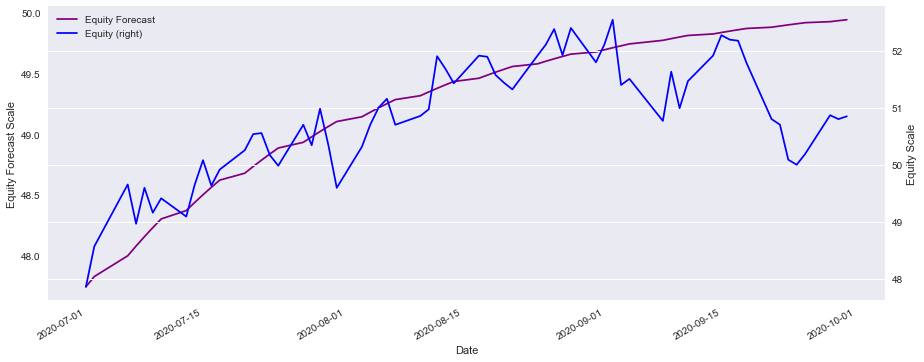

In [153]:
df_VECM_forecast.Equity_FC.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_VECM_forecast.vxus.plot(secondary_y = True, color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

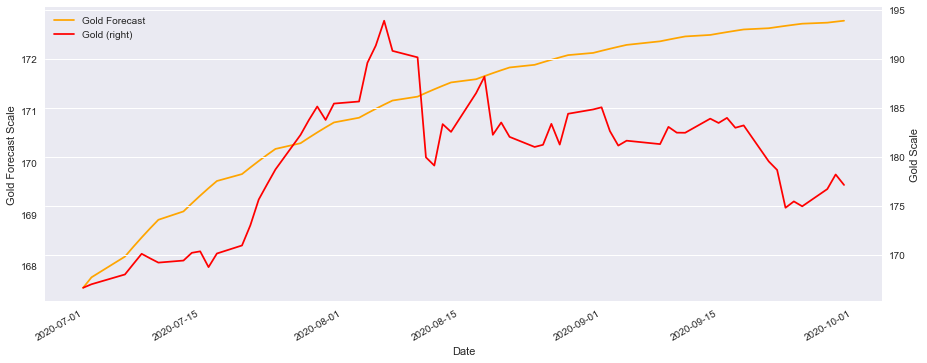

In [154]:
df_VECM_forecast.Gold_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.gold.plot(secondary_y = True,color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

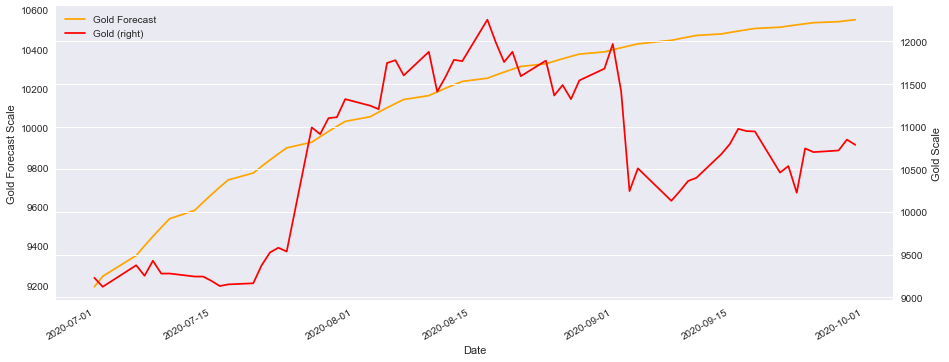

In [155]:
df_VECM_forecast.Bitcoin_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.btc.plot(secondary_y = True,color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

In [156]:
#Calculate forecast bias
forecast_errors = [df_VECM_forecast['vxus'][i]- df_VECM_forecast['Equity_FC'][i] for i in range(len(df_VECM_forecast['vxus']))]
bias = sum(forecast_errors) * 1.0/len(df_VECM_forecast['Equity_FC'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(df_VECM_forecast['vxus'],df_VECM_forecast['Equity_FC'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(df_VECM_forecast['vxus'], df_VECM_forecast['Equity_FC'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 1.572886
MAE: 1.572886
MSE: 2.927350
RMSE: 1.710950


### VECM model for Q3 - train and Q4 - test

In [157]:
# Q3 (Train) and Q4 (Test)

In [158]:
VECM_model = VECM(train_Q3, coint_rank=2)
vecm_res = VECM_model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,0.0424,0.154,0.276,0.783,-0.259,0.344
L1.vxus,0.0159,0.673,0.024,0.981,-1.303,1.335
L1.btc,0.0001,0.001,0.129,0.898,-0.002,0.002
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-0.0307,0.032,-0.946,0.344,-0.094,0.033
L1.vxus,-0.1486,0.142,-1.048,0.295,-0.427,0.129
L1.btc,-3.225e-05,0.000,-0.135,0.893,-0.001,0.000
,coef,std err,z,P>|z|,[0.025,0.975]
L1.gold,-3.1379,20.824,-0.151,0.880,-43.952,37.676
L1.vxus,-78.4215,90.973,-0.862,0.389,-256.725,99.882


In [159]:
x =vecm_res.predict(steps =66)
idx = pd.date_range('2020-10-01', periods = 66, freq='B')
df_VECM_forecast = pd.DataFrame(data =x, index = idx, columns =['Gold_FC','Equity_FC', 'Bitcoin_FC'])
df_VECM_forecast.index.names = ['Date']
df_VECM_forecast = test_Q4.merge(df_VECM_forecast, on='Date')
df_VECM_forecast.head()

,gold,vxus,btc,Gold_FC,Equity_FC,Bitcoin_FC
Date,,,,,,
2020-10-01,178.699997,51.257885,10623.330078,177.325567,50.837183,10747.677277
2020-10-02,178.539993,51.033714,10585.164063,177.586385,50.803582,10718.611605
2020-10-05,179.410004,51.784210,10804.000977,177.834258,50.780451,10702.199547
2020-10-06,177.300003,51.413834,10621.664063,178.066133,50.762876,10693.132462
2020-10-07,177.220001,51.930405,10679.136719,178.280888,50.750512,10690.360101


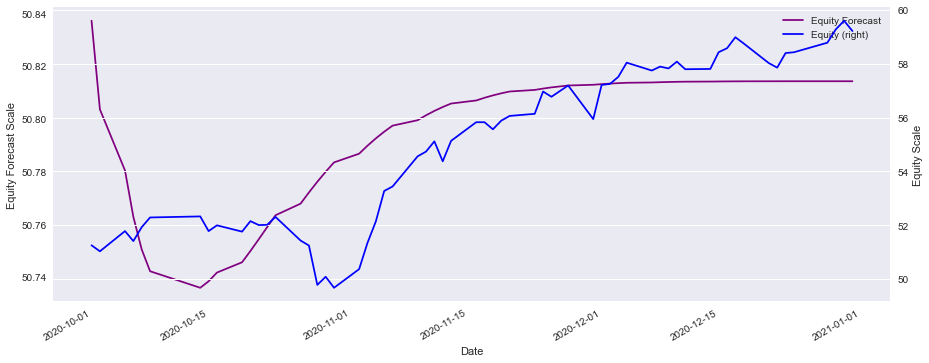

In [160]:
df_VECM_forecast.Equity_FC.plot(figsize=(15,6), color= 'purple', legend=True, label='Equity Forecast').set_ylabel('Equity Forecast Scale')
df_VECM_forecast.vxus.plot(secondary_y = True, color = 'blue',legend = True,label ='Equity').set_ylabel('Equity Scale')
plt.show()

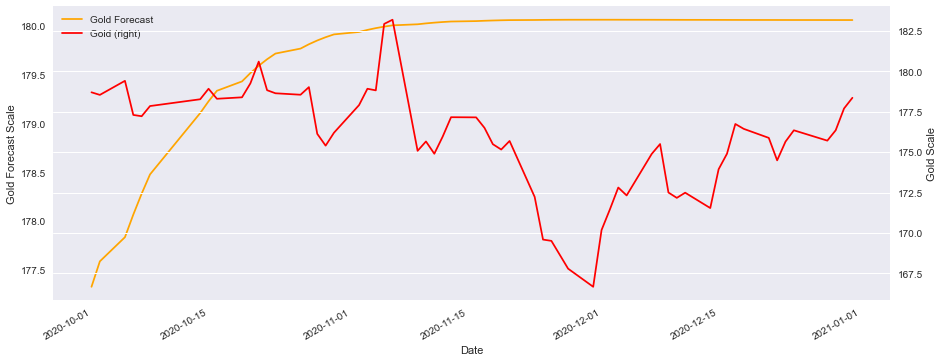

In [161]:
df_VECM_forecast.Gold_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.gold.plot(secondary_y = True, color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

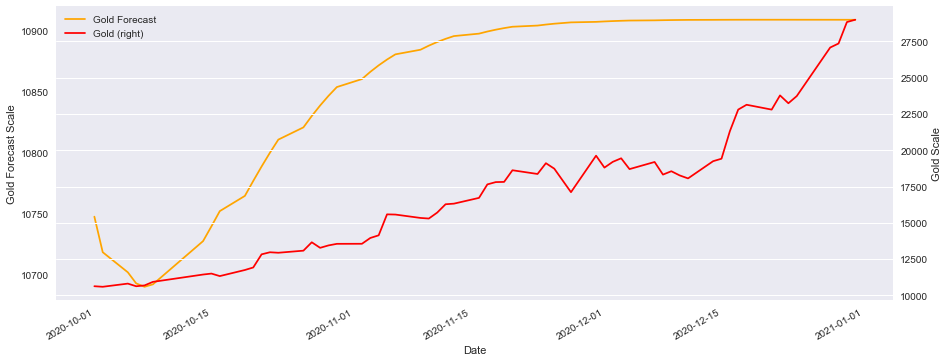

In [162]:
df_VECM_forecast.Bitcoin_FC.plot(figsize=(15,6), color= 'orange', legend=True, label='Gold Forecast').set_ylabel('Gold Forecast Scale')
df_VECM_forecast.btc.plot(secondary_y = True, color = 'red',legend = True,label ='Gold').set_ylabel('Gold Scale')
plt.show()

In [163]:
#Calculate forecast bias
forecast_errors = [df_VECM_forecast['vxus'][i]- df_VECM_forecast['Equity_FC'][i] for i in range(len(df_VECM_forecast['vxus']))]
bias = sum(forecast_errors) * 1.0/len(df_VECM_forecast['Equity_FC'])
print('Bias: %f' % bias)
#Calculate mean absolute error
mae = mean_absolute_error(df_VECM_forecast['vxus'],df_VECM_forecast['Equity_FC'])
print('MAE: %f' % mae)
#Calculate mean squared error and root mean squared error
mse = mean_squared_error(df_VECM_forecast['vxus'], df_VECM_forecast['Equity_FC'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: 4.229531
MAE: 4.334518
MSE: 26.864691
RMSE: 5.183116


### NO. 8 combined

In [ ]:
predictions_ARMA.head()
ARMA=predictions_ARMA
ARMA_GARCH =forecasts['Equity_ARMA_GARCH_Predictions']
VAR = df_test['Equity_FC_VAR']
VECM = df_VECM_forecast['Equity_FC']
Output =pd.concat([ARMA,ARMA_GARCH,VAR,VECM], axis=1)
models =Output[['Equity_ARMA_Predictions','Equity_ARMA_GARCH_Predictions','Equity_FC_VAR','Equity_FC']]
Equity=Output['Equity']
Equity_Final =pd.concat([Equity,Equity,Equity,Equity], axis=1)
list(models.columns.values)
symbol=list(models.columns.values)
num_assets =len(list(models.columns.values))
num_assets
arr = np.random.random(2)
arr
arr[0]+arr[1]
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights
weights[0]+weights[1]+weights[2]+weights[3]

Expected_Price = np.sum(models.mean()*weights)
Actual_Price = np.sum(Equity_Final.mean()*weights)
forecast_error= Actual_Price - Expected_Price
metrics_df = pd.DataFrame(data={
    'Expected Price': Expected_Price,
    'Actual Price': Actual_Price,
    'Forecast_Error':forecast_error
},index=[0])

metrics_df

In [ ]:
num_of_portfolios = 10000
port_expected =[]
port_actuals = []
port_weights = []
port_error=[]

num_portfolios = 1000
individual_rets = models.resample('Y').last().mean()
individual_acts = Equity_Final.resample('Y').last().mean()
individual_acts

In [ ]:
or port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    returns = np.dot(weights,individual_rets)
    port_expected.append(returns)
    
    acts = np.dot(weights,individual_acts)
    port_actuals.append(acts)
data ={'Expected':port_expected, 'Actuals':port_actuals}
for counter, symbol in enumerate(models.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]
portfolios_V1=pd.DataFrame(data)
portfolios_V1 = portfolios_V1.rename(columns={'Equity_FC weight': 'Equity_VECM weight'})
portfolios_V1.head()

In [ ]:
portfolios_V1['forecast_errors']=portfolios_V1['Actuals']-portfolios_V1['Expected']
portfolios_V1['bias']=portfolios_V1['forecast_errors']*0.1/66
portfolios_V1.head()
portfolios_V1['MAE'] =abs((portfolios_V1['Expected']-portfolios_V1['Actuals'])/66)
portfolios_V1.head()
portfolios_V1['MSE']=((portfolios_V1['Actuals']-portfolios_V1['Expected'])**2)/66
portfolios_V1['RMSE']=np.sqrt(portfolios_V1['MSE'])
portfolios_V1.head()
portfolios_V1.iloc[portfolios_V1['RMSE'].idxmin()]
